In [97]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
import pickle
import os

def read_or_pickle(path, load_default):
    path += '.pickle'
    if os.path.isfile(path):
        return pickle.load(open(path, 'rb'))
    else:
        data = load_default()
        pickle.dump(data, open(path, 'wb'))
        return data

def load_book(id):
    return gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(id)).strip()

In [6]:
class CharRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model, n_layers):
        super().__init__()

        self.encoder = nn.Embedding(input_size, hidden_size)
        if model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size) 

    def forward(self, inp, hidden):
        batch_size = inp.size(0)
        encoded = self.encoder(inp)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

In [94]:
def char_tensor(chars_ix):
    return torch.tensor(chars_ix, dtype=torch.long, device=device)


def random_training_set(doc, doc_len, chunk_len, batch_size):
    inp = torch.zeros(batch_size, chunk_len, dtype=torch.long, device=device)
    target = inp.clone()

    for i in range(batch_size):
        start_index = random.randrange(doc_len - (chunk_len + 1))
        end_index = start_index + chunk_len + 1
        chunk = doc[start_index:end_index]
        inp[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])

    return inp, target

In [325]:
def train(vocab, inp, target, net, criterion, optimizer, scheduler, teacher_ratio):
    batch_size = inp.size(0)
    hidden = None
    net.zero_grad()
    loss = 0

    for i in range(inp.size(1)):
        if i == 0 or random.random() < teacher_ratio:
            actual_inp = inp[:, i]
        else:
            actual_inp = torch.zeros(
                batch_size, 1, dtype=torch.long, device=device)
            for bi, max_i in enumerate(last_output.argmax(1)):
                actual_inp[bi] = max_i
        output, hidden = net(actual_inp, hidden)
        output = output.view(batch_size, -1)
        last_output = output
        loss += criterion(output.view(batch_size, -1), target[:, i])

    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item() / inp.size(1)

In [320]:
def run_train(doc,
              doc_len,
              net,
              criterion,
              optimizer,
              scheduler,
              n_epochs,
              chunk_len,
              batch_size,
              teacher_ratio,
              plot_every=1):
    losses = []

    for epoch in tqdm(range(n_epochs)):
        inp, target = random_training_set(doc, doc_len, chunk_len, batch_size)
        loss = train(vocab, inp, target, net, criterion, optimizer, scheduler,
                     teacher_ratio)

        if DEBUG:
            return

        if LIVE_PLOT:
            liveloss.update({'loss': loss / plot_every})
            liveloss.draw()

        losses.append(loss / plot_every)

    plt.figure()
    plt.plot(losses)

    print(f'Final loss: {losses[-1]}')

In [245]:
def to_index(string):
    return list(map(vocab.index, string))


doc = load_book(84)
vocab = list(set(doc))
doc = to_index(doc)
doc_len = len(doc)

In [281]:
PICKLE_DIR = './movie_pickles'
KEEP_LENGTH = 500

def process(movie):
    # important_line_re = re.compile(r'^[A-Z"\'0-9\t -]*[A-Z-][A-Z"\'0-9\t -]*$', re.MULTILINE)
    # if important_line_re.search(movie['text'][KEEP_LENGTH:]):
    #    after_kept = important_line_re.split(movie['text'][KEEP_LENGTH:], 1)[0]
    #    movie['text'] = movie['text'][:KEEP_LENGTH] + after_kept
    # else:
    # movie['text'] = movie['text'][:KEEP_LENGTH]
    return movie

movies = [
    process(pickle.load(open(os.path.join(PICKLE_DIR, movie), 'rb')) )
    for movie in os.listdir(PICKLE_DIR)[:1]
]

chars = ''.join([movie['text'] + movie['plot'] + movie['title'] for movie in movies])
vocab = list(set(chars))

for movie in movies:
    for key in ('text',):
        movie[key] = [vocab.index(char) for char in movie[key]]

doc = movies[0]['text'] # [i for movie in movies for i in movie['text']]
doc_len = len(doc)

In [323]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()
hidden_size = 100
n_layers = 2
model = 'gru'
learning_rate = 0.01
n_epochs = 1000
chunk_len = 100
batch_size = 128
teacher_ratio = 0.9

net = CharRNN(len(vocab), hidden_size, len(vocab), model, n_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)

Final loss: 1.1297644805908202


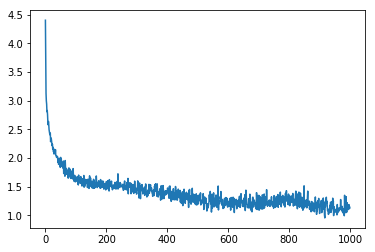

In [326]:
run_train(doc, doc_len, net, criterion, optimizer, scheduler, n_epochs, chunk_len, batch_size, teacher_ratio)


STATES_DIR = './states'
if not os.path.isdir(STATES_DIR):
    os.makedirs(STATES_DIR)
    
i = 0
while True:
    path = os.path.join(STATES_DIR, f'state{i}.pt')
    if not os.path.isfile(path):
        torch.save(net.state_dict(), path)
        break
    i += 1

In [349]:
# net.load_state_dict(torch.load('state.pt'))

def sample(vocab, net, prime_str, predict_len, temperature, beam_number):
    with torch.no_grad():
        prime_str = to_index(prime_str)

        hidden = None
        prime_inp = char_tensor(prime_str).unsqueeze(0)
        for i in range(len(prime_str)):
            _, hidden = net(prime_inp[:, i], hidden)
        
        if not USE_BEAM:
            result = prime_str
            for i in range(predict_len):
                inp = char_tensor(result[-1]).unsqueeze(0)
                output, hidden = net(inp, hidden)
                output_dist = output.data.view(-1).div(temperature).exp()
                result.append(output_dist.argmax().item())

            return ''.join([vocab[i] for i in result])
        
        beams = [(hidden, prime_str)]

        for i in range(predict_len):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                inp = char_tensor(result[-1]).unsqueeze(0)
                output, hidden = net(inp, hidden)
                output_dist = output.data.view(-1).div(temperature).exp()
                output = torch.multinomial(output_dist, output_dist.size()[0])
                print(output)

                output_pairs.extend([
                    (i, out.item(), beami) 
                    for i, out in enumerate(output)])
                new_hidden.append(hidden)

            output_pairs.sort(key=lambda pair: pair[1], reverse=True)

            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                current_result = beams[beami][1]
                new_result = list(current_result)
                new_result.append(outi)
                new_beams.append((new_hidden[beami].clone(), new_result))
            beams = new_beams

        return list(
            map(lambda beam: ''.join(map(lambda i: vocab[i], beam[1])),
                new_beams))



In [350]:
USE_BEAM = True

prime_str = 'How is'
predict_len = 3000
temperature = 0.8
beam_number = 10

res = sample(vocab, net, prime_str, predict_len, temperature, beam_number)

if not USE_BEAM:
    print(res)
else:
    for pred in res:
       print('===START===')
       print(pred)
       print('\n\n')

tensor([16, 74,  3, 56, 63, 55,  2, 17, 10, 60,  6, 76, 14, 31, 13,  7, 45, 38,
        54, 19, 53, 27, 70, 37, 34, 49, 33,  0, 58, 62, 78, 20, 47, 41, 67, 48,
         9, 46, 61, 12, 73, 35,  5, 24, 29, 28, 26, 64, 11,  4, 57, 15, 32, 66,
        21, 77, 72, 36, 69, 18, 68, 23, 30, 22, 39, 51, 44, 75,  1, 42, 65, 40,
        50, 43, 71,  8, 52, 59, 25])
tensor([16, 63, 74,  9,  2, 10, 45, 38, 34, 58, 66, 54, 55, 17, 41, 67,  0, 60,
        20, 46, 43, 27, 15, 39, 42, 32, 14, 29, 28, 33, 35, 53, 76, 56, 69, 49,
        75, 30,  4, 73, 70, 26, 65, 78, 71, 48, 31,  5,  6, 51, 47, 24, 68,  8,
        40, 57, 62, 44, 37, 64, 11,  3,  7, 19, 13, 23, 61, 50, 12, 21, 72, 22,
        59,  1, 77, 52, 18, 36, 25])
tensor([55, 53, 16, 56,  7, 33,  3, 63, 21,  6, 45, 68, 17, 62,  9, 10, 58, 70,
        37, 73, 26, 19, 78, 65, 15, 22, 74, 49, 41, 24, 36, 39, 38, 35,  4, 28,
        46, 20,  2, 75, 25, 30, 31, 50, 12, 76, 72, 34, 57, 64,  0, 14, 32, 66,
        47, 60, 59, 42, 67, 27, 43, 69, 54, 71

tensor([60, 74,  2, 76, 17, 73,  6, 45, 27,  0, 58, 46, 34, 16, 14, 41, 23, 54,
        31, 62, 47, 12, 37, 63, 56, 48, 38,  5, 61, 10,  3, 29,  9, 18, 20, 11,
        69,  1, 44, 77, 66, 13, 36, 43, 32, 55, 26, 42, 72, 19, 75, 53, 33, 30,
        71, 22, 24, 67, 28,  8, 78, 21, 15, 40, 57, 65, 68, 50, 64, 51, 59, 70,
         7, 49, 39, 52, 25, 35,  4])
tensor([56, 16, 63,  3, 19, 73, 55, 10,  2, 74, 27, 33, 41, 78, 60, 58,  0, 76,
        70, 17, 49, 62, 53, 34,  6, 48, 61, 31, 54, 47, 46, 37, 22, 14, 72, 28,
        36, 38, 68, 12, 65, 45, 71, 50, 13, 66, 43,  7, 18,  9, 64, 69, 75, 11,
         4, 44, 42, 59, 67, 24, 23, 52, 57, 21, 40,  5, 51, 30, 29,  1, 39, 15,
        77, 35, 32,  8, 25, 20, 26])
tensor([19, 60,  1, 53, 47, 51, 54, 46, 32, 58, 20, 24, 62,  6, 14, 21, 17, 45,
         9, 73, 41, 22, 63, 75, 29, 34, 50, 37, 36,  2, 23,  3, 61, 31, 10, 59,
        74, 76, 40, 38, 16, 42, 68, 26,  7,  0, 27, 11, 33, 66, 35, 18, 55, 64,
        43, 67, 57, 25, 65, 12, 13, 72,  5, 70

tensor([62, 17, 31, 46, 58, 27,  6, 45, 47, 38, 16,  0, 61, 60, 55, 14, 63,  2,
        74,  3, 56, 12, 18, 34, 54, 53, 76, 10, 49, 73, 33, 37, 40, 19, 71, 78,
        41, 26, 29,  9, 42, 50,  8, 36, 23, 32, 67, 25, 39, 20, 70,  5, 43, 22,
        57, 11,  1, 48, 52, 68, 30, 66, 44, 15, 13,  7, 24, 21, 75, 64, 35, 72,
        65, 69, 59,  4, 28, 51, 77])
tensor([ 9,  7, 45, 65, 64, 40, 13,  2, 72, 23, 62, 39, 26, 60, 34, 17, 16, 56,
        57, 19, 38, 74,  0, 76, 22, 71, 35, 50, 61, 41, 32, 36, 20,  8, 10, 48,
        31, 75, 21,  3, 55, 58, 11, 24, 69,  1, 63, 53, 29,  4, 37, 78, 54, 47,
        42, 43,  5,  6, 46, 51, 15, 68, 67, 73, 59, 33, 25, 27, 28, 66, 18, 30,
        12, 52, 14, 70, 44, 49, 77])
tensor([74, 17,  6, 76,  2, 60, 16, 65, 45, 73, 62, 53,  0, 58,  9, 13, 34, 72,
        26, 31, 46, 33, 40, 56, 54, 30, 63, 14, 23, 27, 19, 32, 38, 47, 61, 35,
        18, 51, 66, 55, 12, 57, 77,  4,  7, 37, 64, 10, 71, 22,  5, 48, 41, 43,
         3, 67, 11,  1, 20,  8, 75, 15, 28, 44

tensor([60, 45,  9, 76, 20, 47, 63, 22, 16, 17,  1, 27, 58,  2, 34, 38, 53, 73,
        32, 40, 41, 59, 24, 26, 74, 37, 72,  6, 23, 75, 19, 65, 48, 14, 21,  7,
        54, 36, 61, 46, 56, 13, 39,  0, 31, 62, 35, 29, 50, 12, 42, 64, 25, 57,
        18,  3, 43, 67, 71, 70, 69,  5, 51, 44, 11, 33, 49,  4, 15, 55, 10, 28,
        68, 77, 30,  8, 66, 78, 52])
tensor([56, 63, 16,  6,  3, 73,  2, 60,  0, 33, 13,  7, 19, 70, 53, 17, 74, 34,
        41, 22,  4, 27, 55, 61, 10, 69, 76, 39, 12, 31, 37, 47, 32, 58, 14, 36,
        62, 52, 28, 24,  8, 77, 75, 54, 23, 49,  9, 42, 64, 66, 11, 15, 45, 65,
        18, 40, 30, 67, 78, 21,  1, 44, 68, 50, 48, 57, 38, 29, 46, 26, 43, 72,
         5, 71, 20, 35, 25, 51, 59])
tensor([65, 16, 56, 63, 40, 64, 58,  9,  3, 22, 35, 57, 24, 75, 74, 19, 23, 20,
        62, 72, 55, 10, 13, 39, 36, 53,  4, 51, 26,  7, 59, 33, 49, 69,  1, 11,
        78, 76, 17, 37, 21, 27,  2, 73, 32, 45, 38, 31, 28,  6, 77, 30, 54, 48,
        25, 43,  5, 50, 44, 71, 70,  0, 61, 60

tensor([56, 76, 58, 63,  9, 75, 62,  7,  3, 65, 27, 41, 54, 37,  0, 17,  2, 57,
        55, 74, 60, 31, 38, 39,  1, 16, 51, 45, 33, 29, 72, 26, 66, 67, 61, 14,
        23,  8, 10, 19, 50, 35, 59, 78, 46, 28, 34, 68, 20, 13, 64, 43, 73, 32,
        11, 53,  5, 48, 70,  6, 36, 40, 24, 30, 15, 71, 22, 42, 44, 47,  4, 69,
        52, 49, 12, 21, 18, 77, 25])
tensor([ 9, 16, 13, 40,  0, 64, 39, 19, 56, 63, 55, 26, 53, 60, 50, 65, 20,  7,
        22, 75,  3, 72, 10,  2, 62,  4, 76, 45, 58, 59, 74, 27, 70, 32, 23, 24,
        34, 33,  1, 35, 78, 57, 17, 68, 54, 14, 41, 49, 42, 21, 73, 36, 43, 15,
        11, 31, 71, 29,  5, 38, 47, 30,  8, 28, 18, 66, 67, 61, 51,  6, 48, 69,
        25, 37, 77, 46, 44, 12, 52])
tensor([ 2, 76, 64, 17, 74, 60, 65, 72, 13, 58, 22, 23,  3, 73,  0,  9, 63, 20,
        34, 56, 31, 47, 62,  6, 14, 24, 35,  7, 26, 16, 10, 41, 46, 40, 38, 12,
        55, 67,  1, 50, 33, 11, 45, 59, 19, 36, 71, 54, 48, 66, 61, 18, 37, 27,
        69, 75, 25, 21, 57, 77, 68, 49, 32, 53

tensor([31,  6, 58, 62, 16, 56, 46, 27,  0, 73, 14, 17, 60, 63, 54, 38, 12,  3,
        41, 53, 10, 74, 45, 76, 19, 23,  2, 47, 37, 50, 18, 55, 34, 33, 48, 70,
        67, 32, 28, 61, 52, 24,  1, 29, 39, 78, 66, 11, 71, 49, 75, 65, 59, 69,
        44, 40, 42, 26, 36, 25, 21, 30, 15, 22, 68, 13,  8, 43,  5, 35, 77, 72,
        64, 20, 57,  7, 51,  4,  9])
tensor([34, 74, 16, 17, 19, 76, 63, 73, 75,  0, 45, 60, 37,  9, 31, 13,  6,  3,
         2, 53, 56, 15, 27, 58, 12, 69, 33, 14, 42, 55, 11, 40,  1, 78, 43, 38,
        47, 70, 62, 10, 41, 36, 39, 48, 46,  7, 72, 66, 67,  8, 77, 54, 32, 65,
        21, 71, 49, 30, 24, 29, 51, 68, 64, 61, 22, 23, 44, 26, 50, 20, 57, 28,
        52, 59, 18,  5,  4, 35, 25])
tensor([27, 16, 54, 58, 56, 10,  3, 55, 17,  6, 23,  2, 19, 50, 63, 60, 41, 29,
        45, 73, 20, 57, 48,  0, 13, 74, 38, 12, 61, 47, 34, 46, 66, 62, 22, 67,
        43,  7,  1, 40, 11, 59, 18, 75, 65,  5, 31, 24, 49, 71, 51, 36, 53, 70,
        76, 14, 39, 44,  9, 78, 21, 28,  8, 77

tensor([58, 60, 74, 33, 10,  6, 38, 17, 16,  2,  3, 34, 63, 76, 55, 46,  0, 23,
        56, 62, 53,  9, 26, 31, 50, 48, 12, 70, 47, 67, 54, 32, 27, 42, 29, 43,
        75, 35, 21,  7, 73, 19, 66, 45, 61, 14, 64, 24, 59, 41, 68,  4, 37,  1,
        20, 11, 78, 30, 22, 15, 49, 44, 36, 65, 72, 51, 71, 57, 13, 69, 77, 25,
        39,  5, 28, 40,  8, 18, 52])
tensor([13, 25,  9, 64,  7, 26,  4, 16, 78, 63, 33, 56, 59, 40, 35, 36, 74, 65,
        20, 17, 22, 32, 72,  2, 60, 19,  1, 53, 50, 51, 75, 55, 68, 23, 66, 67,
        15,  3, 45, 24, 10, 43, 77, 71, 54, 49, 39, 30, 76, 57, 42, 47, 41, 73,
        34, 28, 69,  5, 18, 11,  8, 70, 62, 48, 38,  0, 31, 21, 44, 61, 12,  6,
        46, 27, 14, 37, 58, 29, 52])
tensor([64, 40, 53,  9, 13, 65, 32, 75, 17,  7, 35, 50, 63, 60, 20, 72,  4, 51,
        74, 62, 26, 16, 25, 21, 42, 19,  0,  1, 55, 11, 71, 39, 24, 15, 58, 33,
        45, 22, 23, 56,  5, 73, 67, 34, 48, 59, 61,  2, 76, 31, 66,  8, 46, 69,
        57, 68, 43, 41, 78, 30, 14, 36,  3, 27

tensor([16,  3, 56, 63, 19, 33, 53, 34, 55, 43, 74, 60, 45, 17, 58,  2, 22, 78,
        70, 73,  6, 10, 66, 76,  0,  9,  7, 50, 49, 47, 13, 62, 41, 75, 65, 28,
        64, 27, 69,  4, 15, 31, 38, 40, 36, 12, 21, 37, 71, 77, 39, 18, 68, 42,
        14, 67, 24, 26, 11, 61, 23, 35, 54, 48,  1, 52, 32, 72, 46, 20, 25,  5,
        59,  8, 30, 44, 57, 29, 51])
tensor([16, 56, 53, 65, 22,  7, 63,  9, 64, 33,  3, 36, 57, 55,  4, 17, 72, 78,
        13,  2, 24, 20, 39, 75, 59, 40, 73, 69, 45, 28,  1, 19,  0, 10, 35,  6,
        74, 60, 26, 48, 41, 23, 21, 32, 34, 70, 15, 50, 62, 58, 25, 49, 68, 66,
         5, 14, 43, 76, 31, 27, 11, 42, 77, 47, 71, 37, 38, 30, 12, 18, 67,  8,
        44, 61, 52, 54, 29, 46, 51])
tensor([16, 13, 22, 63, 56,  7,  3, 23, 64, 33, 17,  4, 71, 36, 19, 53,  9,  6,
        65, 60, 10, 24, 32, 39, 59, 26, 55, 62, 40, 66, 50, 72, 20, 74, 57, 58,
        45, 78, 49, 21, 31, 15, 25, 28, 70, 41, 61,  1, 35, 30, 47, 73, 76, 69,
         2, 67, 68, 11, 34, 42, 48, 12, 77, 43

tensor([16, 55,  9, 63, 64, 56, 13, 39,  3, 72, 36, 33, 65, 19, 53,  4, 75,  7,
        49, 32, 40, 57, 26, 20, 10, 50, 41, 22, 34, 74, 45,  2, 17,  1, 28, 35,
        78, 15, 76, 37, 14, 23,  0, 24, 70, 60, 69,  6, 30, 12, 62, 59, 66, 48,
        77, 68, 67, 21, 42, 71, 27, 73, 25, 51, 31, 46, 58, 47, 38,  5, 52, 18,
        11, 43, 61, 44,  8, 29, 54])
tensor([ 9, 13, 56, 64, 60,  2, 19, 17, 46, 74, 76, 63, 16, 73,  0, 41, 22, 72,
        23, 47, 53, 70, 10, 40, 58, 33, 24, 62,  7, 27, 14, 65,  3, 26, 36, 35,
        31, 38, 57, 50, 20, 21, 54, 59, 75, 45,  1, 28, 77, 71,  6, 34, 78, 11,
        32, 49, 42,  8, 18,  4, 43, 55, 61, 44, 15,  5, 39, 68, 25, 67, 30, 66,
        29, 69, 12, 37, 48, 52, 51])
tensor([13, 40, 16, 36, 22,  7, 26, 39, 57, 65, 64,  9, 56, 23, 20,  2, 72, 75,
        24, 25, 50, 63, 17, 74, 33, 35,  4, 10, 19, 32, 62, 69, 60, 59, 53,  5,
        15, 71, 34, 11, 41, 55, 61,  3,  1, 58, 51, 76,  6, 14, 48, 21, 38, 28,
        45, 42, 78, 27, 68, 43, 70, 30, 67, 73

tensor([ 7, 22, 16,  3, 13, 56, 59, 39, 63, 65, 64, 19, 35, 20, 75, 55,  4, 72,
         9, 24, 36, 26, 77, 32, 53, 34, 50, 78, 58, 33, 14,  6, 41, 40, 70, 49,
        48, 71,  2, 15,  1, 21, 45,  0, 37, 11, 17, 30, 42, 62, 60, 25, 23, 76,
        47, 10, 52, 54, 74, 67, 28, 66, 18, 68, 69, 51, 12, 73, 61, 57, 44, 29,
         5, 31, 38, 27,  8, 46, 43])
tensor([72, 13,  2, 63, 55,  9, 45, 17, 74, 60, 40, 27, 62, 73, 65,  0, 33, 19,
        61, 64, 23,  7, 15,  3, 22, 16, 76, 66, 57, 26, 39, 58, 34, 56, 69, 53,
         6, 68, 41, 11, 78, 20, 71, 42, 38, 37, 31, 32, 14, 35, 59, 30, 70,  8,
        36, 67, 48, 47, 10, 25, 29, 50, 44,  5, 21, 49, 12,  4,  1, 43, 24, 75,
        18, 46, 77, 54, 28, 51, 52])
tensor([ 6, 35, 34,  1, 21, 26, 41, 60, 62, 39, 46, 45, 56,  7, 22, 17, 58,  0,
        47, 36, 14,  2, 64, 24, 32, 72, 69,  9, 38, 23, 27, 57, 76, 31, 59, 13,
        74, 29, 20, 61, 40, 11, 53, 73, 66, 65, 37, 28, 16, 54, 63,  5, 50, 51,
        48, 75, 42, 71,  4, 10, 12,  8, 18, 15

tensor([16, 40, 56, 65, 19, 36, 72, 63, 24,  9,  2, 23, 73, 59, 62, 26, 58, 75,
        35, 54,  3, 13, 74, 50, 64, 45,  6, 32, 22, 53,  1, 78, 51, 43, 20, 47,
        38, 25,  7, 17, 39, 55, 60, 34, 21, 48, 49, 57,  0, 37, 61, 41, 27, 76,
        31,  8, 14, 10, 70, 77,  5, 12, 71, 30, 46,  4, 69, 42, 18, 33, 68, 11,
        66, 52, 44, 67, 15, 28, 29])
tensor([17,  9, 33, 13, 58, 75, 67, 40, 71, 42, 15, 74,  3, 45, 19, 22, 10, 63,
        27, 60, 20, 66, 16, 49, 32, 64, 48, 23, 56, 57, 73,  4, 28, 53,  0, 11,
         8, 25, 36, 76, 50, 72,  2, 26, 62, 52, 69, 68, 24,  7, 30, 38, 77, 12,
        41, 70,  1, 34, 47, 78, 43, 65, 55, 35, 44, 61, 51,  5, 31, 54, 14, 29,
        37, 21, 18, 59, 46, 39,  6])
tensor([16, 56,  3, 53, 19, 58, 63, 23, 55, 50, 74, 33, 78, 22,  2,  4, 66, 17,
        13, 70, 60, 75,  0,  7, 73, 49,  6, 10, 32, 62, 15, 64, 35, 65, 45, 11,
        14, 77, 34, 40, 27, 24, 36, 54,  9, 28, 76, 38,  8, 20, 69, 47, 31, 59,
        68, 25, 39, 43, 41, 71, 26, 72, 67, 30

tensor([74, 13, 63, 16, 56, 17, 19, 40,  7,  3, 64, 32, 72, 60, 25,  2, 23, 78,
         9, 33, 73, 59, 35, 45, 22, 55, 76, 57, 77, 49, 34, 47, 36,  5, 43, 58,
        24, 20,  1, 75, 26, 27, 65, 62, 53, 51, 54, 15, 70, 10, 14, 11, 68,  4,
        31, 28, 69,  8, 38,  6, 67, 71, 41, 66, 39, 42, 44,  0, 50, 21, 30, 46,
        12, 48, 37, 61, 18, 52, 29])
tensor([74, 72, 13, 64,  7, 26, 32,  2, 17, 60, 57, 40, 15, 22, 59, 76,  9, 65,
        62, 50, 35, 45, 71, 68, 67, 10, 66, 16, 20, 75, 42,  0, 31,  4, 30, 48,
        27, 61,  8, 23,  3, 24, 19, 53, 73, 11, 14, 43, 38, 51, 18, 46,  6, 58,
        56, 25, 37, 55, 63, 34,  1, 44, 41, 36, 54, 39,  5, 69, 77, 33, 29, 21,
        47, 70, 12, 49, 78, 28, 52])


KeyboardInterrupt: 